In [75]:
from qiskit import *
from qiskit.aqua.circuits.gates import cry
from qiskit.visualization import plot_histogram
import numpy as np

In [82]:
theta = np.pi/4

In [77]:
# Build a sub-circuit
sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name='sub_circ')
sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.iden(sub_q[1])
sub_circ.u3(1, 2, -2, sub_q[0])

# Convert to a gate and stick it into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

​q = QuantumRegister(3, 'q')
circ = QuantumCircuit(q)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [q[1], q[2]])

circ.draw(output='mpl')


SyntaxError: invalid character in identifier (<ipython-input-77-18e9bd5c34c7>, line 13)

In [121]:
def timelapse(qc, fen, env, measure, theta):
    sub_q = QuantumRegister(2) #0 fen, 1 env
    sub_c = ClassicalRegister(1) #measure
    decoherence = QuantumCircuit(sub_q, sub_c, name='decoherence')
    decoherence.ry(theta, sub_q[1])
    decoherence.cx(sub_q[0], sub_q[1])
    decoherence.ry(-theta, sub_q[1])
    decoherence.cx(sub_q[1], sub_q[0])
    decoherence.measure([sub_q[1]],[sub_c[0]])
    decoherence.reset(sub_q[1])
    dec_inst = decoherence.to_instruction()
    qc.append(dec_inst, [fen, env], [measure])

    

In [123]:
def muchos_timelapse(qc, fen, env, measure, theta, n):
    #sub_q = QuantumRegister(2)
    #sub_c = ClassicalRegister(1) #0 fen, 1 env
    #decoherence = QuantumCircuit(sub_q, sub_c, name='decoherence n={}'.format(n))
    for i in range(0, n):
        timelapse(qc, fen, env, measure, theta)
    #dec_inst = decoherence.to_instruction()
    #qc.append(dec_inst, [fen, env], [measure])

In [213]:
def epoch(qc, index, theta, env, mutation=0):
    for i in range(0, index):
        timelapse(qc, fen=2*i+1, env=env, measure=0, theta=theta)
    qc.barrier()
    qc.cx(2*index,2*(index+1))
    qc.cx(2*(index+1),2*(index+1) + 1)
    qc.barrier()
    if mutation != 0:
        x = np.random.normal(loc=0, scale=mutation)
        qc.rx(x, 2*(index+1))
        y = np.random.normal(loc=0, scale=mutation)
        qc.ry(y, 2*(index+1))
        qc.barrier()

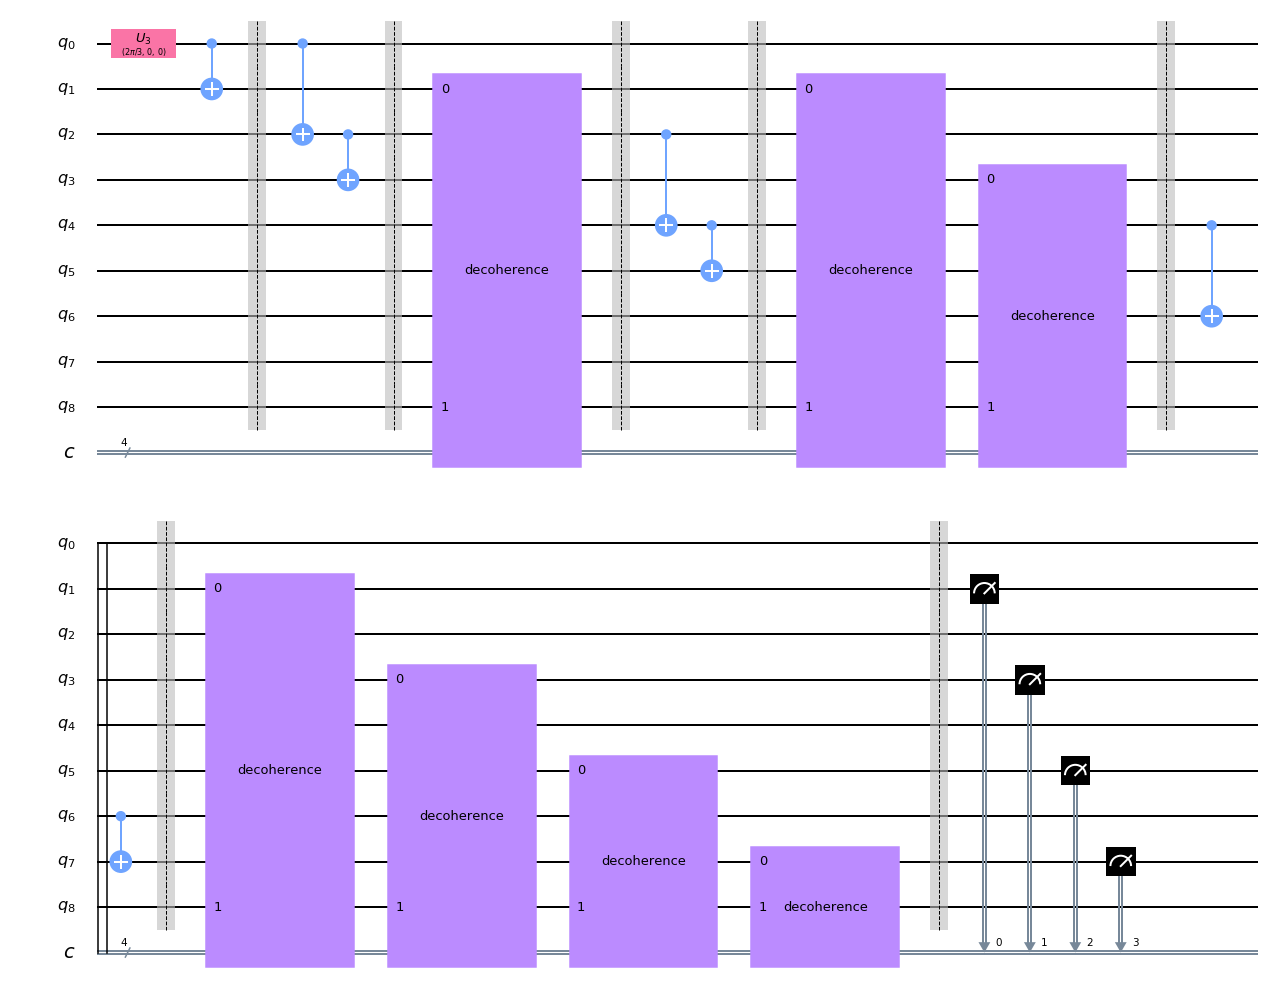

In [219]:
epoch_num = 4
qc = QuantumCircuit(2*epoch_num+1,epoch_num)
qc.u3(2*np.pi/3,0,0,0)
#qc.x(0)
qc.cx(0,1)
for i in range(0, epoch_num-1):
    epoch(qc, i, theta, env=2*epoch_num)
for i in range(0, epoch_num):
    muchos_timelapse(qc, fen=2*i+1, env=2*epoch_num, measure=0, theta=theta, n=1)
qc.barrier()
for i in range(0, epoch_num):
    qc.measure([2*i+1],[i])
qc.draw(output='mpl')

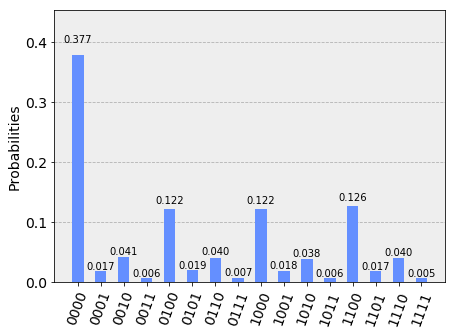

In [220]:
sim = Aer.get_backend('qasm_simulator') 
# the device to run on

job3 = execute(qc, sim, shots=8192)

# Grab results from the job
result3 = job3.result()

# Returns counts
counts3 = result3.get_counts()
plot_histogram(counts3)

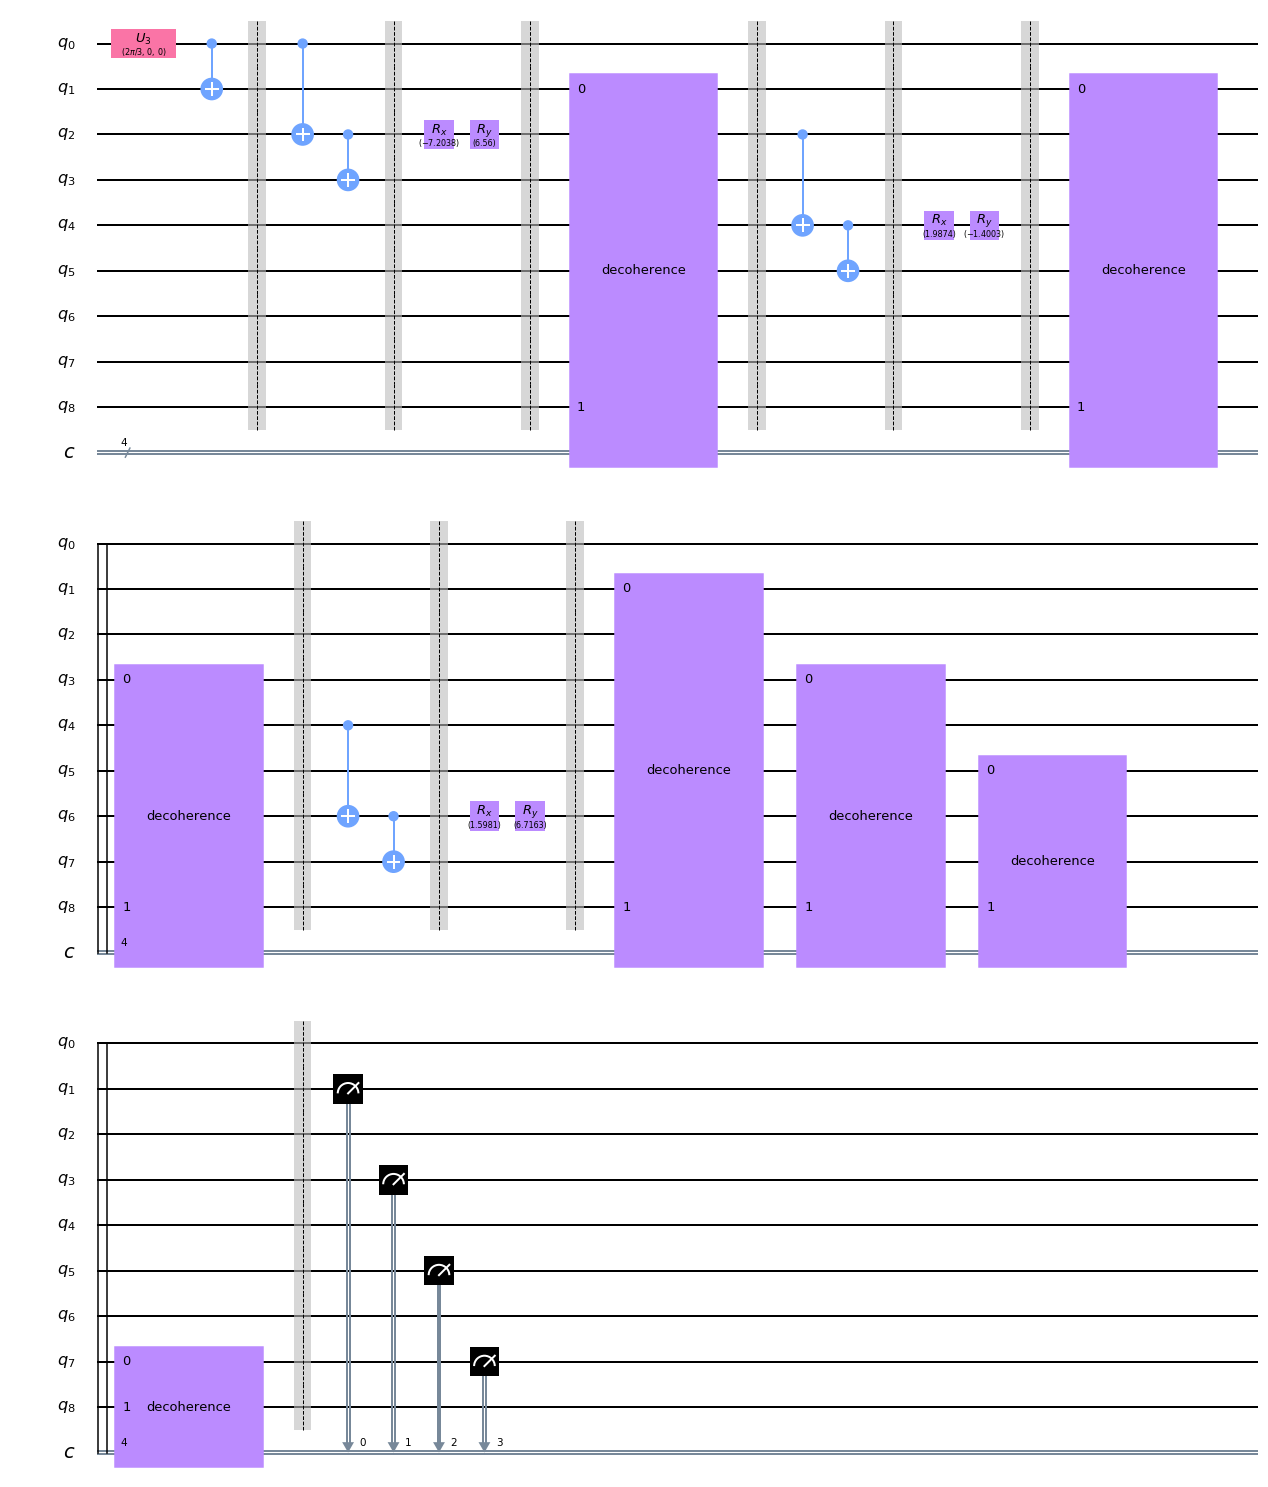

In [221]:
epoch_num = 4
qc = QuantumCircuit(2*epoch_num+1,epoch_num)
qc.u3(2*np.pi/3,0,0,0)
#qc.x(0)
qc.cx(0,1)
for i in range(0, epoch_num-1):
    epoch(qc, i, theta, env=2*epoch_num, mutation=np.pi)
for i in range(0, epoch_num):
    muchos_timelapse(qc, fen=2*i+1, env=2*epoch_num, measure=0, theta=theta, n=1)
qc.barrier()
for i in range(0, epoch_num):
    qc.measure([2*i+1],[i])
qc.draw(output='mpl')

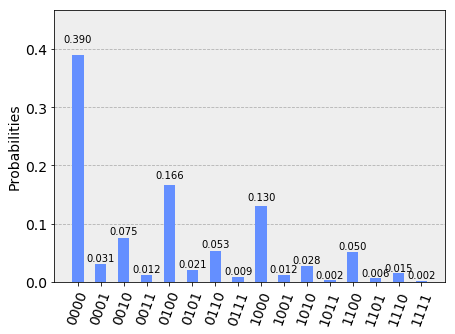

In [222]:
sim = Aer.get_backend('qasm_simulator') 
# the device to run on

job3 = execute(qc, sim, shots=8192)

# Grab results from the job
result3 = job3.result()

# Returns counts
counts3 = result3.get_counts()
plot_histogram(counts3)